## comparison between temperatures in two separate years for a location

In [1]:
import json
from sqlalchemy import create_engine
import pandas as pd

In [2]:
creds = json.load(open('dbcreds.json','r'))
engine = create_engine(f"postgresql://{creds['DB_USER']}:{creds['DB_PW']}@{creds['DB_SERVER']}:{creds['DB_PORT']}/{creds['DB_DBNAME']}")

In [3]:
# find a nice rural place

In [4]:
lat1, lon1 = 20.4820,75.6120
radiusKm = 40

In [5]:
s2 = f"""select sr, ST_Y(geometry) as lon, ST_X(geometry) as lat,
ST_Distance(geometry::geography, ST_GeogFromText('SRID=4326;POINT({lon1} {lat1})'))/1000 as distance
from temp_grid
where ST_DWithin(
    geometry::geography, 
    ST_GeogFromText('SRID=4326;POINT({lon1} {lat1})'), 
    {radiusKm*1000} )
order by ST_Distance(geometry, ST_GeomFromText('POINT({lon1} {lat1})',4326));
"""
print(s2)

select sr, ST_Y(geometry) as lon, ST_X(geometry) as lat,
ST_Distance(geometry::geography, ST_GeogFromText('SRID=4326;POINT(75.612 20.482)'))/1000 as distance
from temp_grid
where ST_DWithin(
    geometry::geography, 
    ST_GeogFromText('SRID=4326;POINT(75.612 20.482)'), 
    40000 )
order by ST_Distance(geometry, ST_GeomFromText('POINT(75.612 20.482)',4326));



In [6]:
df2 = pd.read_sql(s2, con=engine)
df2

,sr,lon,lat,distance
0,492,20.5,75.5,11.852432


In [7]:
lat2, lon2 = 20.50,75.50
y1 = 1960
y2 = 2020

In [8]:
s1 = f"""select year1, month1, data from imd_temp_data
where year1 in ({y1},{y2})
and ST_Y(geometry)={lat2}
and ST_X(geometry)={lon2}
order by year1, month1
"""
print(s1)

select year1, month1, data from imd_temp_data
where year1 in (1960,2020)
and ST_Y(geometry)=20.5
and ST_X(geometry)=75.5
order by year1, month1



In [9]:
df1 = pd.read_sql(s1, con=engine)
df1

,year1,month1,data
0,1960,1,"{'1960-01-01': {'tmax': 30.3700008392334, 'tmi..."
1,1960,2,"{'1960-02-01': {'tmax': 32.65999984741211, 'tm..."
2,1960,3,"{'1960-03-01': {'tmax': 34.369998931884766, 't..."
3,1960,4,"{'1960-04-01': {'tmax': 39.18000030517578, 'tm..."
4,1960,5,"{'1960-05-01': {'tmax': 41.040000915527344, 't..."
5,1960,6,"{'1960-06-01': {'tmax': 36.72999954223633, 'tm..."
6,1960,7,"{'1960-07-01': {'tmax': 31.75, 'tmin': 23.0799..."
7,1960,8,"{'1960-08-01': {'tmax': 28.850000381469727, 't..."
8,1960,9,"{'1960-09-01': {'tmax': 32.16999816894531, 'tm..."
9,1960,10,"{'1960-10-01': {'tmax': 33.97999954223633, 'tm..."


In [10]:
tableY1 = []
tableY2 = []
for N,r in df1.iterrows():
    if r['year1'] == y1:
        for date1 in r['data'].keys():
            row = r['data'][date1]
            dt = date1.split('-')[-1]
            mo = date1.split('-')[1]
            trow = {'MD': f"{mo}-{dt}", 'y1_tmax':row.get('tmax',''),
                'y1_tmin':row.get('tmin','') }
            tableY1.append(trow)
    elif r['year1'] == y2:
         for date1 in r['data'].keys():
            row = r['data'][date1]
            dt = date1.split('-')[-1]
            mo = date1.split('-')[1]
            trow = {'MD': f"{mo}-{dt}", 'y2_tmax':row.get('tmax',''),
                'y2_tmin':row.get('tmin','') }
            tableY2.append(trow)

In [11]:
y1_df = pd.DataFrame(tableY1)
y2_df = pd.DataFrame(tableY2)

In [12]:
y1_df

,MD,y1_tmax,y1_tmin
0,01-01,30.370001,14.820000
1,01-02,29.980000,16.940001
2,01-03,27.620001,16.639999
3,01-04,28.879999,17.170000
4,01-05,28.750000,16.870001
...,...,...,...
361,12-27,32.910000,14.590000
362,12-28,32.290001,14.600000
363,12-29,31.660000,14.670000
364,12-30,31.440001,14.570000


In [13]:
comdf1 = pd.merge(y1_df, y2_df, on='MD', how='inner')

In [14]:
comdf1

,MD,y1_tmax,y1_tmin,y2_tmax,y2_tmin
0,01-01,30.370001,14.820000,26.034576,14.154064
1,01-02,29.980000,16.940001,26.015392,15.587719
2,01-03,27.620001,16.639999,23.811193,15.447334
3,01-04,28.879999,17.170000,25.162399,13.214811
4,01-05,28.750000,16.870001,24.860918,11.508814
...,...,...,...,...,...
361,12-27,32.910000,14.590000,31.256884,13.761765
362,12-28,32.290001,14.600000,29.173279,13.559561
363,12-29,31.660000,14.670000,28.177170,12.093554
364,12-30,31.440001,14.570000,27.559723,13.258788


## Visualization

References:  
- plotting multiple lines from https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/
- controlling size from https://www.geeksforgeeks.org/change-plot-size-in-matplotlib-python/
- ticks and grid lines from https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
- labels, title from https://pythonbasics.org/matplotlib-line-chart

for later:  
- make it interactive: http://mpld3.github.io/examples/interactive_legend.html

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


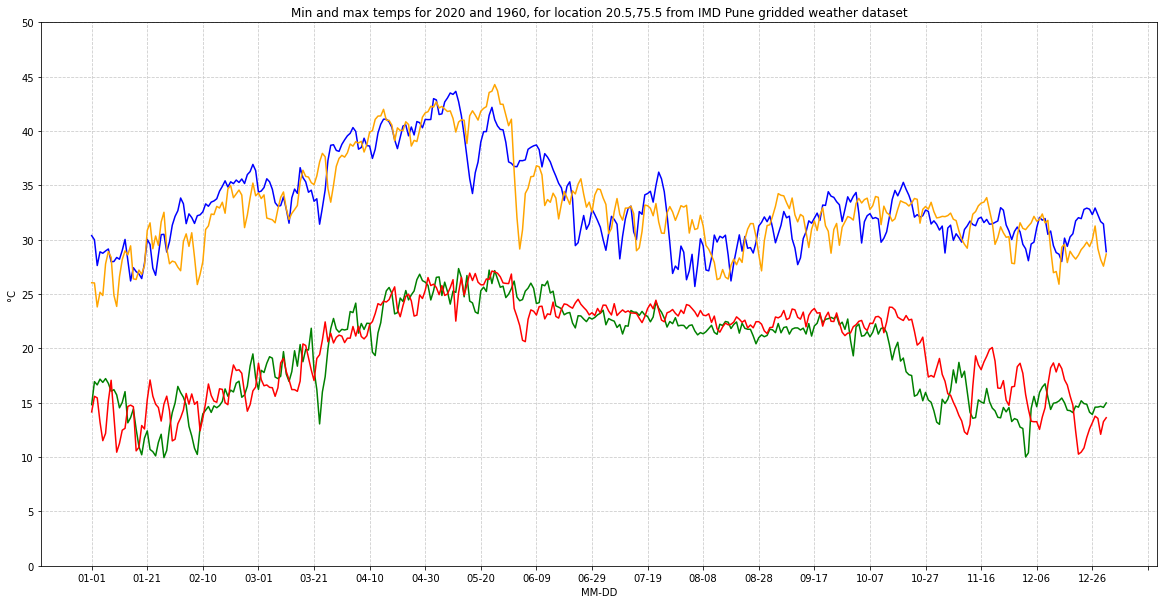

In [16]:
# tmax, tmin of 2 yrs superimposed
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

# Set axis ranges; by default this will put major ticks every 25.
# ax.set_xlim(0, 200)
ax.set_ylim(0, 50)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(5))

# grid
ax.grid(which='major', color='#CCCCCC', linestyle='--')

plt.plot(comdf1['MD'],comdf1['y1_tmax'], label='Y1 max', color='blue')
plt.plot(comdf1['MD'],comdf1['y2_tmax'], label='Y2 max', color='orange')

plt.plot(comdf1['MD'],comdf1['y1_tmin'], label='Y1 min', color='green')
plt.plot(comdf1['MD'],comdf1['y2_tmin'], label='Y2 min', color='red')

plt.xlabel("MM-DD")
plt.ylabel("°C")
plt.title(f"Min and max temps for {y2} and {y1}, for location {lat2},{lon2} from IMD Pune gridded weather dataset")

# plt.legend()
plt.show()

In [17]:
# temp diff bw Y1, Y2
comdf1['diff_tmax'] = comdf1['y2_tmax'] - comdf1['y1_tmax']
comdf1['diff_tmin'] = comdf1['y2_tmin'] - comdf1['y1_tmin']
comdf1

,MD,y1_tmax,y1_tmin,y2_tmax,y2_tmin,diff_tmax,diff_tmin
0,01-01,30.370001,14.820000,26.034576,14.154064,-4.335424,-0.665936
1,01-02,29.980000,16.940001,26.015392,15.587719,-3.964607,-1.352282
2,01-03,27.620001,16.639999,23.811193,15.447334,-3.808807,-1.192665
3,01-04,28.879999,17.170000,25.162399,13.214811,-3.717600,-3.955189
4,01-05,28.750000,16.870001,24.860918,11.508814,-3.889082,-5.361187
...,...,...,...,...,...,...,...
361,12-27,32.910000,14.590000,31.256884,13.761765,-1.653116,-0.828236
362,12-28,32.290001,14.600000,29.173279,13.559561,-3.116722,-1.040440
363,12-29,31.660000,14.670000,28.177170,12.093554,-3.482830,-2.576446
364,12-30,31.440001,14.570000,27.559723,13.258788,-3.880278,-1.311212


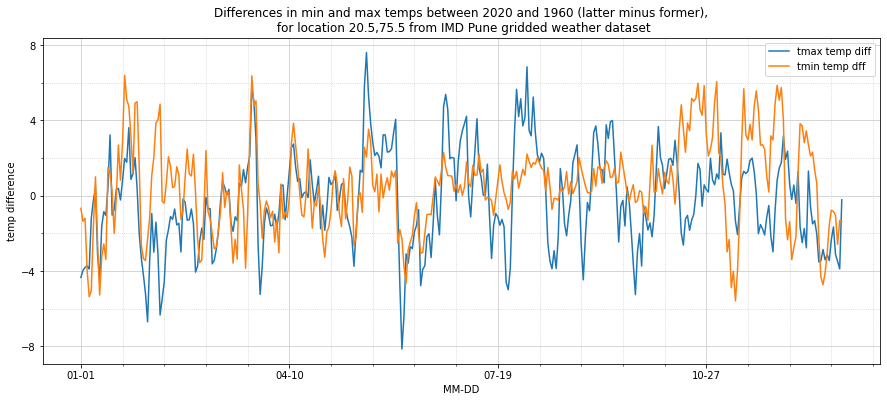

In [18]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(2))

# grid
ax.grid(which='major', color='#CCCCCC', linestyle='-')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.plot(comdf1['MD'],comdf1['diff_tmax'], label='tmax temp diff')
plt.plot(comdf1['MD'],comdf1['diff_tmin'], label='tmin temp dff')

plt.xlabel("MM-DD")
plt.ylabel("temp difference")
plt.title(f"Differences in min and max temps between {y2} and {y1} (latter minus former),\n for location {lat2},{lon2} from IMD Pune gridded weather dataset")

plt.legend()
plt.show()

In [22]:
# summing up the differences between max temps of 2020-1960
comdf1['diff_tmax'].sum()

-80.88626098632812

In [20]:
# summing up the differences between min temps of 2020-1960
comdf1['diff_tmin'].sum()

176.58288192749023

In [23]:
# indicates that 2020's highs were lower than 1960's highs cumulatively,
# and their lows were higher than 1960'w lows cumulatively